In [1]:
import os

import pandas as pd
import numpy as np

from scipy import stats
from tqdm import tqdm
import optuna

from sklearn.model_selection import GridSearchCV
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization import plot_optimization_history

from sklearn.datasets import load_boston 
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, \
    mean_squared_log_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from get_metrics import get_metrics_regression


from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import catboost as cb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

RAND = 10
N_FOLDS = 5

# Импорт данных и предобработка

In [2]:
cian = pd.read_csv('data/cian.csv').drop_duplicates()

In [3]:
col_cats = cian.select_dtypes('object').columns
cian[col_cats] = cian[col_cats].astype('category')

In [4]:
cian[:5]

,author,link,floor,floors_count,rooms_count,total_meters,price,district,street,underground,...,entertainment_infrastructure_rating,square,population,housing_fund_area,line_count,author_count,floor_position,author_more,house_category,population_density
0,Sminex-Интеко,https://www.cian.ru/sale/flat/281914898/,3,5,2,67.07,149930000,Тверской,None,Площадь Революции,...,100,7.27,77864,1253.3,1,193,0,1,2,10710.32
1,MR Group,https://www.cian.ru/sale/flat/285682464/,3,10,2,62.70,34485000,Беговой,Северный ао,Белорусская,...,97,5.56,42781,791.1,4,307,0,1,3,7694.42
2,GloraX,https://www.cian.ru/sale/flat/277738124/,5,21,2,77.85,34069999,Беговой,1-я Ямского Поля,Белорусская,...,97,5.56,42781,791.1,4,40,0,1,5,7694.42
3,ANT Development,https://www.cian.ru/sale/flat/283856161/,27,32,2,50.90,40703799,Дорогомилово,Поклонная,Парк Победы,...,96,7.95,76093,1906.2,4,86,0,1,5,9571.45
4,Sminex-Интеко,https://www.cian.ru/sale/flat/281051002/,6,14,2,85.60,187560000,Якиманка,None,Полянка,...,98,4.80,27672,788.7,1,193,0,1,4,5765.00


In [5]:
cian.link.nunique()

11660

In [6]:
cian.drop(['link', 'price_per_m2'], axis=1, inplace=True)

In [7]:
col_int = [
    'insufficient_infrastructure', 'convenient_for_life',
    'very_convenient_for_life', 'few_entertainment', 'cultural',
    'entertainment', 'cultural_entertainment', 
    'residential_infrastructure_rating', 'entertainment_infrastructure_rating',
    'eco_rating', 'population', 'floor', 'floors_count', 'rooms_count',
    'author_count', 'line_count', 'floor_position', 'author_more', 'house_category'
]

for i in col_int:
    cian[i] = cian[i].astype('int32')

In [8]:
col_float = cian.select_dtypes('float64').columns
for i in col_float:
    cian[i] = cian[i].astype('float32')

In [9]:
cian.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12159 entries, 0 to 12158
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   author                               12159 non-null  category
 1   floor                                12159 non-null  int32   
 2   floors_count                         12159 non-null  int32   
 3   rooms_count                          12159 non-null  int32   
 4   total_meters                         12159 non-null  float32 
 5   price                                12159 non-null  int64   
 6   district                             12159 non-null  category
 7   street                               12159 non-null  category
 8   underground                          12159 non-null  category
 9   residential_complex                  12159 non-null  category
 10  author_type                          12159 non-null  category
 11  line           

In [10]:
cian['population_density'].max()

30428.76953125

In [11]:
cian.describe()

,floor,floors_count,rooms_count,total_meters,price,eco_rating,insufficient_infrastructure,convenient_for_life,very_convenient_for_life,few_entertainment,...,entertainment_infrastructure_rating,square,population,housing_fund_area,line_count,author_count,floor_position,author_more,house_category,population_density
count,12159.000000,12159.000000,12159.000000,12159.000000,1.215900e+04,12159.000000,12159.000000,12159.000000,12159.000000,12159.000000,...,12159.000000,12159.000000,12159.000000,12159.000000,12159.000000,12159.000000,12159.000000,12159.000000,12159.000000,12159.000000
mean,10.019409,19.369603,2.336376,90.149788,5.733351e+07,3.955424,14.153055,35.186035,25.764372,27.925076,...,44.286126,7.489999,78669.403158,1475.440796,1.456123,232.953039,0.264660,0.880829,4.104367,8769.637695
std,9.980510,14.136630,1.587970,72.566063,1.002343e+08,3.099170,16.821700,29.110715,28.697559,34.081925,...,39.291370,6.484011,56756.517451,1133.817749,0.901842,356.605949,0.640412,0.324003,1.187357,6222.408203
min,-1.000000,-1.000000,-1.000000,-1.000000,2.450000e+06,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,0.000000,0.000000,1.000000,1.000000
25%,3.000000,9.000000,1.000000,38.200001,1.110000e+07,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.110000,27672.000000,385.500000,1.000000,20.000000,0.000000,1.000000,3.000000,4604.810059
50%,7.000000,17.000000,2.000000,64.699997,2.289222e+07,5.000000,9.000000,32.000000,15.000000,13.000000,...,35.000000,7.570000,83712.000000,1416.400024,1.000000,86.000000,0.000000,1.000000,5.000000,9882.480469
75%,14.000000,25.000000,4.000000,122.800003,6.344312e+07,6.000000,21.000000,60.000000,52.000000,60.000000,...,83.000000,11.700000,127819.000000,2312.699951,2.000000,262.000000,0.000000,1.000000,5.000000,13225.089844
max,92.000000,97.000000,5.000000,941.700012,2.107580e+09,9.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,27.570000,253943.000000,4523.000000,12.000000,1282.000000,2.000000,1.000000,6.000000,30428.769531


In [12]:
cian.describe(include=['category'])

,author,district,street,underground,residential_complex,author_type,line,area
count,12159,12159,12159,12159,12159,12159,12159,12159
unique,1643,124,1254,288,755,8,17,11
top,ПИК,None,None,None,None,real_estate_agent,None,None
freq,1089,1277,2405,295,4502,4585,1633,2900


In [14]:
def remove_outliers(df, column, threshold=1.5):
    data = df[column].values
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    upper_bound = q3 + threshold * iqr

    filtered_df = df[df[column] <= upper_bound]
    return filtered_df

In [15]:
cian = remove_outliers(cian, 'price')

In [16]:
cian.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10947 entries, 1 to 12158
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   author                               10947 non-null  category
 1   floor                                10947 non-null  int32   
 2   floors_count                         10947 non-null  int32   
 3   rooms_count                          10947 non-null  int32   
 4   total_meters                         10947 non-null  float32 
 5   price                                10947 non-null  int64   
 6   district                             10947 non-null  category
 7   street                               10947 non-null  category
 8   underground                          10947 non-null  category
 9   residential_complex                  10947 non-null  category
 10  author_type                          10947 non-null  category
 11  line           

Для выбора подходящих моделей проверим распределение на нормальность

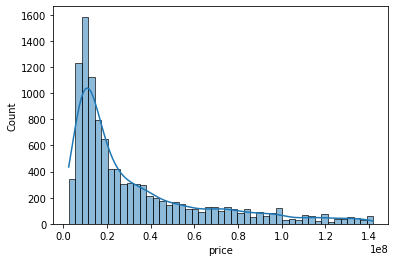

In [17]:
sns.histplot(cian['price'], kde=True);

In [18]:
cian['price'].max()

141803209

In [19]:
cian['price'].min()

2450000

In [20]:
cian.shape

(10947, 32)

In [21]:
test_shapiro = stats.shapiro(cian['price'])

print(test_shapiro)

if test_shapiro.pvalue < 0.05:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

ShapiroResult(statistic=0.7930243015289307, pvalue=0.0)
Распределение не нормальное


Так как распределение ненормальное, произведём логорифмирование целевой переменной

In [22]:
cian['price_log'] = np.log(cian.price)

In [23]:
cian.columns

Index(['author', 'floor', 'floors_count', 'rooms_count', 'total_meters',
       'price', 'district', 'street', 'underground', 'residential_complex',
       'author_type', 'line', 'area', 'eco_rating',
       'insufficient_infrastructure', 'convenient_for_life',
       'very_convenient_for_life', 'few_entertainment', 'cultural',
       'entertainment', 'cultural_entertainment',
       'residential_infrastructure_rating',
       'entertainment_infrastructure_rating', 'square', 'population',
       'housing_fund_area', 'line_count', 'author_count', 'floor_position',
       'author_more', 'house_category', 'population_density', 'price_log'],
      dtype='object')

In [24]:
test_shapiro = stats.shapiro(cian['price_log'])

print(test_shapiro)

if test_shapiro.pvalue < 0.05:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

ShapiroResult(statistic=0.9669340252876282, pvalue=2.942726775082116e-44)
Распределение не нормальное


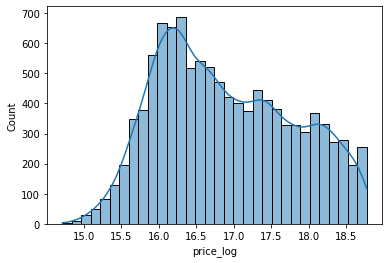

In [25]:
sns.histplot(cian['price_log'], kde=True);


После логарифмирования распределение осталось ненормальным, поэтому линейная регрессия скорее всего не покажет хороших результатов.

Но так как визуально распределение приближено к нормальному, можно посмотреть какие результаты покажет линейная регрессия 


In [26]:
cian_bin = pd.get_dummies(cian, drop_first=True)

In [27]:
cian_bin[:6]

,floor,floors_count,rooms_count,total_meters,price,eco_rating,insufficient_infrastructure,convenient_for_life,very_convenient_for_life,few_entertainment,...,area_ВАО,area_ЗАО,area_Зеленоградский округ,area_САО,area_СВАО,area_СЗАО,area_ЦАО,area_ЮАО,area_ЮВАО,area_ЮЗАО
1,3,10,2,62.700001,34485000,5,9,36,55,0,...,0,0,0,1,0,0,0,0,0,0
2,5,21,2,77.849998,34069999,5,9,36,55,0,...,0,0,0,1,0,0,0,0,0,0
3,27,32,2,50.900002,40703799,6,12,15,73,0,...,0,1,0,0,0,0,0,0,0,0
5,13,15,2,80.300003,36689070,-1,-1,-1,-1,-1,...,0,0,0,0,0,0,0,0,0,0
6,12,17,2,60.099998,22830461,9,60,24,16,11,...,0,0,0,0,0,0,0,1,0,0
7,17,32,2,86.000000,56343416,9,60,24,16,11,...,0,0,0,0,0,0,0,1,0,0


# Построение baseline

In [28]:
X = cian.drop(columns=['price', 'price_log'],
                  axis=1)
y = cian['price'].values
y_log = cian['price_log'].values

In [29]:
X_train_bin, X_test_bin, y_train, y_test = train_test_split(
    pd.get_dummies(X),
    y,
    test_size=0.2,
    random_state=RAND)

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    pd.get_dummies(X),
    y_log,
    test_size=0.2,
    random_state=RAND)

y_test_exp = np.exp(y_test_log)
y_train_exp = np.exp(y_train_log)

mms = MinMaxScaler()
X_train_std = mms.fit_transform(X_train_log)
X_test_std = mms.transform(X_test_log)


# без бинаризации
X[X.select_dtypes('object').columns] = X[X.select_dtypes('object').columns].astype('category')

X_train = X.loc[X_train_bin.index]
X_test = X.loc[X_test_bin.index]

cat_features = X.select_dtypes('category').columns.tolist()

## Linear Regression Baseline

In [30]:
lr = LinearRegression()
lr.fit(X_train_std, y_train_log)

LinearRegression()

In [31]:
y_pred = lr.predict(X_test_std)
y_pred_exp = np.exp(y_pred)

max_value = np.max(y_pred_exp[np.isfinite(y_pred_exp)])
y_pred_exp[~np.isfinite(y_pred_exp)] = max_value

metrics = get_metrics_regression(y_test_exp,
                                 y_pred_exp,
                                 X_test_std,
                                 name='LinearRegression')
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression,3.427937e+07,7.119601e+15,8.437773e+07,4.972061,9.059787,-205.399054,233.354714,104.446687


In [32]:
def check_overfitting_df(model, X_train, y_train, X_test, y_test, metric_fun, name):
    """
    Проверка на overfitting и добавление в таблицу
    """
    df_check_overfitting = pd.DataFrame()
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    value_train = metric_fun(y_train, y_pred_train)
    value_test = metric_fun(y_test, y_pred_test)
    
    df_check_overfitting['model'] = [name]

    df_check_overfitting['metric'] = [metric_fun.__name__]
    df_check_overfitting['value_train'] = [value_train]
    df_check_overfitting['value_test'] = [value_test]
    df_check_overfitting['overfitting'] = [abs(value_train - value_test)/value_test*100]
    
    return df_check_overfitting

In [33]:
overfitting = check_overfitting_df(lr, X_train_std, y_train_exp, X_test_std, y_test_exp,
                  mean_absolute_error, 'LinearRegression')
overfitting

,model,metric,value_train,value_test,overfitting
0,LinearRegression,mean_absolute_error,3.296733e+07,3.497627e+08,90.574374


## Ridge Baseline

In [34]:
ridge = Ridge(random_state=RAND)
ridge.fit(X_train_std, y_train_log)
r_pred = ridge.predict(X_test_std)
r_pred_exp = np.exp(r_pred)

max_value = np.max(r_pred_exp[np.isfinite(r_pred_exp)])
r_pred_exp[~np.isfinite(r_pred_exp)] = max_value

In [35]:
r_pred_train = ridge.predict(X_train_std)
r_pred_train_exp = np.exp(r_pred_train)

max_value = np.max(r_pred_train_exp[np.isfinite(r_pred_train_exp)])
r_pred_train_exp[~np.isfinite(r_pred_train_exp)] = max_value

In [36]:
metrics = metrics.append(
    get_metrics_regression(y_test_exp, r_pred_exp, X_test_std, name='Ridge'))
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression,3.427937e+07,7.119601e+15,8.437773e+07,4.972061,9.059787,-205.399054,233.354714,104.446687
0,Ridge,6.128995e+06,1.750312e+14,1.322993e+07,0.223316,1.198145,-2.867063,16.982589,18.674590


In [37]:
overfitting = overfitting.append(
    check_overfitting_df(ridge, X_train_std, y_train_exp, X_test_std,
                         y_test_exp, mean_absolute_error, 'Ridge'))
overfitting

,model,metric,value_train,value_test,overfitting
0,LinearRegression,mean_absolute_error,3.296733e+07,3.497627e+08,90.574374
0,Ridge,mean_absolute_error,3.296733e+07,3.281995e+07,0.449049


In [38]:
coeffecients_ridge = pd.DataFrame()
coeffecients_ridge['feature'] = pd.get_dummies(X).columns
coeffecients_ridge['score'] = ridge.coef_
coeffecients_ridge.sort_values(by='score', ascending=False)[:10]

,feature,score
3,total_meters,2.452151
2,rooms_count,0.996211
1895,street_3/6 этаж,0.806931
1906,street_4/7 этаж,0.709256
2440,street_Маршала Соколовского,0.586367
3773,residential_complex_Лаврушинский ЖК,0.555078
2050,street_Большой Николоворобинский переулок,0.547394
1876,street_3-й Обыденский переулок,0.542603
3221,underground_Площадь Революции,0.533981
3695,residential_complex_Ильинка 3/8 ЖК,0.533981


## Lasso Baseline

In [39]:
lasso = Lasso(random_state=RAND)
lasso.fit(X_train_std, y_train_log)
l_pred_test = lasso.predict(X_test_std)
l_pred_test_exp = np.exp(l_pred_test)

max_value = np.max(l_pred_test_exp[np.isfinite(l_pred_test_exp)])
l_pred_test_exp[~np.isfinite(l_pred_test_exp)] = max_value

In [40]:
metrics = metrics.append(
    get_metrics_regression(y_test_exp, l_pred_test_exp, X_test_std, name='Lasso'))
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression,3.427937e+07,7.119601e+15,8.437773e+07,4.972061,9.059787,-205.399054,233.354714,104.446687
0,Ridge,6.128995e+06,1.750312e+14,1.322993e+07,0.223316,1.198145,-2.867063,16.982589,18.674590
0,Lasso,2.207242e+07,1.120539e+15,3.347445e+07,0.900197,2.268513,-43.004182,89.167551,67.253019


In [41]:
overfitting = overfitting.append(
    check_overfitting_df(lasso, X_train_std, y_train_exp, X_test_std, y_test_exp,
                  mean_absolute_error, 'Lasso'))
overfitting

,model,metric,value_train,value_test,overfitting
0,LinearRegression,mean_absolute_error,3.296733e+07,3.497627e+08,90.574374
0,Ridge,mean_absolute_error,3.296733e+07,3.281995e+07,0.449049
0,Lasso,mean_absolute_error,3.296733e+07,3.281995e+07,0.449049


In [42]:
coeffecients_lasso = pd.DataFrame()
coeffecients_lasso['feature'] = pd.get_dummies(X).columns
coeffecients_lasso['score'] = lasso.coef_
coeffecients_lasso.sort_values(by='score', ascending=False)[:10]

,feature,score
0,floor,0.0
2706,street_Серпуховский Вал,0.0
2740,street_Сочинская,-0.0
2741,street_Спартаковская площадь,-0.0
2742,street_Спиридоновка,0.0
2743,street_Спиридоньевский переулок,0.0
2744,street_Средний Тишинский переулок,0.0
2745,street_Средняя Калитниковская,-0.0
2746,street_Средняя Первомайская,0.0
2747,street_Средняя Переяславская,-0.0


## ElasticNet Baseline

In [43]:
elastic = ElasticNet(random_state=RAND)
elastic.fit(X_train_std, y_train_log)
e_pred_test = elastic.predict(X_test_std)
e_pred_test_exp = np.exp(l_pred_test)

max_value = np.max(e_pred_test_exp[np.isfinite(e_pred_test_exp)])
e_pred_test_exp[~np.isfinite(e_pred_test_exp)] = max_value

In [44]:
metrics = metrics.append(
    get_metrics_regression(y_test_exp, e_pred_test_exp, X_test_std, name='Elastic'))
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression,3.427937e+07,7.119601e+15,8.437773e+07,4.972061,9.059787,-205.399054,233.354714,104.446687
0,Ridge,6.128995e+06,1.750312e+14,1.322993e+07,0.223316,1.198145,-2.867063,16.982589,18.674590
0,Lasso,2.207242e+07,1.120539e+15,3.347445e+07,0.900197,2.268513,-43.004182,89.167551,67.253019
0,Elastic,2.207242e+07,1.120539e+15,3.347445e+07,0.900197,2.268513,-43.004182,89.167551,67.253019


In [45]:
overfitting = overfitting.append(
    check_overfitting_df(elastic, X_train_std, y_train_exp, X_test_std, y_test_exp,
                  mean_absolute_error, 'Elastic'))
overfitting

,model,metric,value_train,value_test,overfitting
0,LinearRegression,mean_absolute_error,3.296733e+07,3.497627e+08,90.574374
0,Ridge,mean_absolute_error,3.296733e+07,3.281995e+07,0.449049
0,Lasso,mean_absolute_error,3.296733e+07,3.281995e+07,0.449049
0,Elastic,mean_absolute_error,3.296733e+07,3.281995e+07,0.449049


## XGBRegressor Baseline

In [46]:
X_train_, X_val, y_train_, y_val = train_test_split(X_train_bin,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    random_state=RAND)

clf = XGBRegressor(random_state=RAND)
eval_set = [(X_val, y_val)]

clf.fit(X_train_,
        y_train_,
        eval_metric="mae",
        eval_set=eval_set,
        early_stopping_rounds=100,
        verbose=0)

y_pred = clf.predict(X_test_bin)

In [49]:
metrics = metrics.append(get_metrics_regression(y_test=y_test,
                                 y_pred=y_pred,
                                 X_test=X_test,
                                 name='XGBoost'))
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression,3.427937e+07,7.119601e+15,8.437773e+07,4.972061,9.059787,-205.399054,233.354714,104.446687
0,Ridge,6.128995e+06,1.750312e+14,1.322993e+07,0.223316,1.198145,-2.867063,16.982589,18.674590
0,Lasso,2.207242e+07,1.120539e+15,3.347445e+07,0.900197,2.268513,-43.004182,89.167551,67.253019
0,Elastic,2.207242e+07,1.120539e+15,3.347445e+07,0.900197,2.268513,-43.004182,89.167551,67.253019
0,XGBoost,5.369706e+06,9.044609e+13,9.510315e+06,0.209958,0.908238,-4.143991,16.448621,16.361095
0,XGBoost,5.369706e+06,9.044609e+13,9.510315e+06,0.209958,0.908238,-4.143991,16.448621,16.361095


In [50]:
overfitting = overfitting.append(
    check_overfitting_df(clf, X_train_, y_train_, X_test_bin, y_test,
                         mean_absolute_error, 'XGBoost'))
overfitting

,model,metric,value_train,value_test,overfitting
0,LinearRegression,mean_absolute_error,3.296733e+07,3.497627e+08,90.574374
0,Ridge,mean_absolute_error,3.296733e+07,3.281995e+07,0.449049
0,Lasso,mean_absolute_error,3.296733e+07,3.281995e+07,0.449049
0,Elastic,mean_absolute_error,3.296733e+07,3.281995e+07,0.449049
0,XGBoost,mean_absolute_error,3.671218e+06,5.369706e+06,31.630937


## LGBMRegressor Baseline

In [51]:
X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    random_state=RAND)

eval_set = [(X_val, y_val)]

In [52]:
lgbm = LGBMRegressor(random_state=RAND, objective='mae')
eval_set = [(X_val, y_val)]

lgbm.fit(X_train_,
        y_train_,
        eval_metric="mae",
        eval_set=eval_set,
        verbose=False,
        early_stopping_rounds=100)

y_pred_lgbm = lgbm.predict(X_test)

In [53]:
metrics = metrics.append(get_metrics_regression(y_test=y_test,
                           y_pred=y_pred_lgbm,
                           X_test=X_test,
                           name='LGBoost'))
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression,3.427937e+07,7.119601e+15,8.437773e+07,4.972061,9.059787,-205.399054,233.354714,104.446687
0,Ridge,6.128995e+06,1.750312e+14,1.322993e+07,0.223316,1.198145,-2.867063,16.982589,18.674590
0,Lasso,2.207242e+07,1.120539e+15,3.347445e+07,0.900197,2.268513,-43.004182,89.167551,67.253019
0,Elastic,2.207242e+07,1.120539e+15,3.347445e+07,0.900197,2.268513,-43.004182,89.167551,67.253019
0,XGBoost,5.369706e+06,9.044609e+13,9.510315e+06,0.209958,0.908238,-4.143991,16.448621,16.361095
0,XGBoost,5.369706e+06,9.044609e+13,9.510315e+06,0.209958,0.908238,-4.143991,16.448621,16.361095
0,LGBoost,5.278812e+06,1.071487e+14,1.035127e+07,0.197673,0.891292,-1.119359,13.747154,16.084149


In [56]:
get_metrics_regression(y_test=y_test,
                           y_pred=y_pred_lgbm,
                           X_test=X_test,
                           name='LGBoost')

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LGBoost,5.278812e+06,1.071487e+14,1.035127e+07,0.197673,0.891292,-1.119359,13.747154,16.084149


In [57]:
overfitting = overfitting.append(
    check_overfitting_df(lgbm, X_train_, y_train_, X_test, y_test,
                  mean_absolute_error, 'LGBoost'))
overfitting

,model,metric,value_train,value_test,overfitting
0,LinearRegression,mean_absolute_error,3.296733e+07,3.497627e+08,90.574374
0,Ridge,mean_absolute_error,3.296733e+07,3.281995e+07,0.449049
0,Lasso,mean_absolute_error,3.296733e+07,3.281995e+07,0.449049
0,Elastic,mean_absolute_error,3.296733e+07,3.281995e+07,0.449049
0,XGBoost,mean_absolute_error,3.671218e+06,5.369706e+06,31.630937
0,LGBoost,mean_absolute_error,4.030106e+06,5.278812e+06,23.655057


### dart

In [58]:
lgbm = LGBMRegressor(boosting_type='dart',random_state=RAND, objective='mae')

lgbm.fit(X_train_,
        y_train_,
        eval_metric="mae",
        eval_set=eval_set,
        verbose=False,
        early_stopping_rounds=100)

y_pred_lgbm = lgbm.predict(X_test)

In [59]:
metrics = metrics.append(
    get_metrics_regression(y_test=y_test,
                           y_pred=y_pred_lgbm,
                           X_test=X_test,
                           name='LGBoost_dart'))
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression,3.427937e+07,7.119601e+15,8.437773e+07,4.972061,9.059787,-205.399054,233.354714,104.446687
0,Ridge,6.128995e+06,1.750312e+14,1.322993e+07,0.223316,1.198145,-2.867063,16.982589,18.674590
0,Lasso,2.207242e+07,1.120539e+15,3.347445e+07,0.900197,2.268513,-43.004182,89.167551,67.253019
0,Elastic,2.207242e+07,1.120539e+15,3.347445e+07,0.900197,2.268513,-43.004182,89.167551,67.253019
0,XGBoost,5.369706e+06,9.044609e+13,9.510315e+06,0.209958,0.908238,-4.143991,16.448621,16.361095
0,XGBoost,5.369706e+06,9.044609e+13,9.510315e+06,0.209958,0.908238,-4.143991,16.448621,16.361095
0,LGBoost,5.278812e+06,1.071487e+14,1.035127e+07,0.197673,0.891292,-1.119359,13.747154,16.084149
0,LGBoost_dart,2.434850e+07,7.880885e+14,2.807291e+07,NaN,0.200446,121.245889,121.284371,74.188080


In [60]:
overfitting = overfitting.append(
    check_overfitting_df(lgbm, X_train_, y_train_, X_test, y_test,
                  mean_absolute_error, 'LGBoost_dart'))
overfitting

,model,metric,value_train,value_test,overfitting
0,LinearRegression,mean_absolute_error,3.296733e+07,3.497627e+08,90.574374
0,Ridge,mean_absolute_error,3.296733e+07,3.281995e+07,0.449049
0,Lasso,mean_absolute_error,3.296733e+07,3.281995e+07,0.449049
0,Elastic,mean_absolute_error,3.296733e+07,3.281995e+07,0.449049
0,XGBoost,mean_absolute_error,3.671218e+06,5.369706e+06,31.630937
0,LGBoost,mean_absolute_error,4.030106e+06,5.278812e+06,23.655057
0,LGBoost_dart,mean_absolute_error,2.438955e+07,2.434850e+07,0.168586


### goss

In [61]:
lgbm = LGBMRegressor(boosting_type='goss',random_state=RAND, objective='mae')

lgbm.fit(X_train_,
        y_train_,
        eval_metric="mae",
        eval_set=eval_set,
        verbose=False,
        early_stopping_rounds=100)

y_pred_lgbm = lgbm.predict(X_test)

In [62]:
metrics = metrics.append(
    get_metrics_regression(y_test=y_test,
                           y_pred=y_pred_lgbm,
                           X_test=X_test,
                           name='LGBoost_goss'))
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression,3.427937e+07,7.119601e+15,8.437773e+07,4.972061,9.059787,-205.399054,233.354714,104.446687
0,Ridge,6.128995e+06,1.750312e+14,1.322993e+07,0.223316,1.198145,-2.867063,16.982589,18.674590
0,Lasso,2.207242e+07,1.120539e+15,3.347445e+07,0.900197,2.268513,-43.004182,89.167551,67.253019
0,Elastic,2.207242e+07,1.120539e+15,3.347445e+07,0.900197,2.268513,-43.004182,89.167551,67.253019
0,XGBoost,5.369706e+06,9.044609e+13,9.510315e+06,0.209958,0.908238,-4.143991,16.448621,16.361095
0,XGBoost,5.369706e+06,9.044609e+13,9.510315e+06,0.209958,0.908238,-4.143991,16.448621,16.361095
0,LGBoost,5.278812e+06,1.071487e+14,1.035127e+07,0.197673,0.891292,-1.119359,13.747154,16.084149
0,LGBoost_dart,2.434850e+07,7.880885e+14,2.807291e+07,NaN,0.200446,121.245889,121.284371,74.188080
0,LGBoost_goss,5.278812e+06,1.071487e+14,1.035127e+07,0.197673,0.891292,-1.119359,13.747154,16.084149


In [63]:
overfitting = overfitting.append(
    check_overfitting_df(lgbm, X_train_, y_train_, X_test, y_test,
                  mean_absolute_error, 'LGBoost_goss'))
overfitting

,model,metric,value_train,value_test,overfitting
0,LinearRegression,mean_absolute_error,3.296733e+07,3.497627e+08,90.574374
0,Ridge,mean_absolute_error,3.296733e+07,3.281995e+07,0.449049
0,Lasso,mean_absolute_error,3.296733e+07,3.281995e+07,0.449049
0,Elastic,mean_absolute_error,3.296733e+07,3.281995e+07,0.449049
0,XGBoost,mean_absolute_error,3.671218e+06,5.369706e+06,31.630937
0,LGBoost,mean_absolute_error,4.030106e+06,5.278812e+06,23.655057
0,LGBoost_dart,mean_absolute_error,2.438955e+07,2.434850e+07,0.168586
0,LGBoost_goss,mean_absolute_error,4.030106e+06,5.278812e+06,23.655057


### rf

In [64]:
lgbm = LGBMRegressor(boosting_type='rf',
                     bagging_fraction=0.8,
                     bagging_freq = 5,
                     feature_fraction = 0.8,
                     random_state=RAND,
                     objective='mae')

lgbm.fit(X_train_,
         y_train_,
         eval_metric="mae",
         eval_set=eval_set,
         verbose=False,
         early_stopping_rounds=100)

y_pred_lgbm = lgbm.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [65]:
metrics = metrics.append(
    get_metrics_regression(y_test=y_test,
                           y_pred=y_pred_lgbm,
                           X_test=X_test,
                           name='LGBoost_rf'))
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression,3.427937e+07,7.119601e+15,8.437773e+07,4.972061,9.059787,-205.399054,233.354714,104.446687
0,Ridge,6.128995e+06,1.750312e+14,1.322993e+07,0.223316,1.198145,-2.867063,16.982589,18.674590
0,Lasso,2.207242e+07,1.120539e+15,3.347445e+07,0.900197,2.268513,-43.004182,89.167551,67.253019
0,Elastic,2.207242e+07,1.120539e+15,3.347445e+07,0.900197,2.268513,-43.004182,89.167551,67.253019
0,XGBoost,5.369706e+06,9.044609e+13,9.510315e+06,0.209958,0.908238,-4.143991,16.448621,16.361095
0,XGBoost,5.369706e+06,9.044609e+13,9.510315e+06,0.209958,0.908238,-4.143991,16.448621,16.361095
0,LGBoost,5.278812e+06,1.071487e+14,1.035127e+07,0.197673,0.891292,-1.119359,13.747154,16.084149
0,LGBoost_dart,2.434850e+07,7.880885e+14,2.807291e+07,NaN,0.200446,121.245889,121.284371,74.188080
0,LGBoost_goss,5.278812e+06,1.071487e+14,1.035127e+07,0.197673,0.891292,-1.119359,13.747154,16.084149
0,LGBoost_rf,1.029168e+07,3.279689e+14,1.810991e+07,0.362569,0.667260,-8.008239,29.840064,31.357989


In [66]:
overfitting = overfitting.append(
    check_overfitting_df(lgbm, X_train_, y_train_, X_test, y_test,
                  mean_absolute_error, 'LGBoost_rf'))
overfitting

,model,metric,value_train,value_test,overfitting
0,LinearRegression,mean_absolute_error,3.296733e+07,3.497627e+08,90.574374
0,Ridge,mean_absolute_error,3.296733e+07,3.281995e+07,0.449049
0,Lasso,mean_absolute_error,3.296733e+07,3.281995e+07,0.449049
0,Elastic,mean_absolute_error,3.296733e+07,3.281995e+07,0.449049
0,XGBoost,mean_absolute_error,3.671218e+06,5.369706e+06,31.630937
0,LGBoost,mean_absolute_error,4.030106e+06,5.278812e+06,23.655057
0,LGBoost_dart,mean_absolute_error,2.438955e+07,2.434850e+07,0.168586
0,LGBoost_goss,mean_absolute_error,4.030106e+06,5.278812e+06,23.655057
0,LGBoost_rf,mean_absolute_error,1.023954e+07,1.029168e+07,0.506640


## CatBoost Baseline

In [67]:
cat_features = X_val.select_dtypes('category').columns.tolist()

ctb = CatBoostRegressor(allow_writing_files=False,
                        random_state=RAND,
                        eval_metric="MAE",
                        cat_features=cat_features)
eval_set = [(X_val, y_val)]

ctb.fit(X_train_,
        y_train_,
        eval_set=eval_set,
        verbose=False)

y_pred = ctb.predict(X_test)

In [68]:
metrics = metrics.append(get_metrics_regression(y_test=y_test,
                           y_pred=y_pred,
                           X_test=X_test,
                           name='CatBoost'))
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression,3.427937e+07,7.119601e+15,8.437773e+07,4.972061,9.059787,-205.399054,233.354714,104.446687
0,Ridge,6.128995e+06,1.750312e+14,1.322993e+07,0.223316,1.198145,-2.867063,16.982589,18.674590
0,Lasso,2.207242e+07,1.120539e+15,3.347445e+07,0.900197,2.268513,-43.004182,89.167551,67.253019
0,Elastic,2.207242e+07,1.120539e+15,3.347445e+07,0.900197,2.268513,-43.004182,89.167551,67.253019
0,XGBoost,5.369706e+06,9.044609e+13,9.510315e+06,0.209958,0.908238,-4.143991,16.448621,16.361095
0,XGBoost,5.369706e+06,9.044609e+13,9.510315e+06,0.209958,0.908238,-4.143991,16.448621,16.361095
0,LGBoost,5.278812e+06,1.071487e+14,1.035127e+07,0.197673,0.891292,-1.119359,13.747154,16.084149
0,LGBoost_dart,2.434850e+07,7.880885e+14,2.807291e+07,NaN,0.200446,121.245889,121.284371,74.188080
0,LGBoost_goss,5.278812e+06,1.071487e+14,1.035127e+07,0.197673,0.891292,-1.119359,13.747154,16.084149
0,LGBoost_rf,1.029168e+07,3.279689e+14,1.810991e+07,0.362569,0.667260,-8.008239,29.840064,31.357989


In [69]:
overfitting = overfitting.append(check_overfitting_df(ctb, X_train_, y_train_, X_test, y_test,
                                   mean_absolute_error, 'CatBoost'))
overfitting

,model,metric,value_train,value_test,overfitting
0,LinearRegression,mean_absolute_error,3.296733e+07,3.497627e+08,90.574374
0,Ridge,mean_absolute_error,3.296733e+07,3.281995e+07,0.449049
0,Lasso,mean_absolute_error,3.296733e+07,3.281995e+07,0.449049
0,Elastic,mean_absolute_error,3.296733e+07,3.281995e+07,0.449049
0,XGBoost,mean_absolute_error,3.671218e+06,5.369706e+06,31.630937
0,LGBoost,mean_absolute_error,4.030106e+06,5.278812e+06,23.655057
0,LGBoost_dart,mean_absolute_error,2.438955e+07,2.434850e+07,0.168586
0,LGBoost_goss,mean_absolute_error,4.030106e+06,5.278812e+06,23.655057
0,LGBoost_rf,mean_absolute_error,1.023954e+07,1.029168e+07,0.506640
0,CatBoost,mean_absolute_error,3.730458e+06,4.997343e+06,25.351174


### CatBoost LinarModel

In [70]:
ctb_lin = CatBoostRegressor(boosting_type='Ordered',
                            allow_writing_files=False,
                            random_state=RAND,
                            eval_metric="MAE",
                            cat_features=cat_features)
ctb_lin.fit(X_train_,
        y_train_,
        eval_set=eval_set,
        verbose=False)

y_pred = ctb_lin.predict(X_test)

In [71]:
metrics = metrics.append(
    get_metrics_regression(y_test=y_test,
                           y_pred=y_pred,
                           X_test=X_test,
                           name='CatBoost_LinearModel'))
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression,3.427937e+07,7.119601e+15,8.437773e+07,4.972061,9.059787,-205.399054,233.354714,104.446687
0,Ridge,6.128995e+06,1.750312e+14,1.322993e+07,0.223316,1.198145,-2.867063,16.982589,18.674590
0,Lasso,2.207242e+07,1.120539e+15,3.347445e+07,0.900197,2.268513,-43.004182,89.167551,67.253019
0,Elastic,2.207242e+07,1.120539e+15,3.347445e+07,0.900197,2.268513,-43.004182,89.167551,67.253019
0,XGBoost,5.369706e+06,9.044609e+13,9.510315e+06,0.209958,0.908238,-4.143991,16.448621,16.361095
0,XGBoost,5.369706e+06,9.044609e+13,9.510315e+06,0.209958,0.908238,-4.143991,16.448621,16.361095
0,LGBoost,5.278812e+06,1.071487e+14,1.035127e+07,0.197673,0.891292,-1.119359,13.747154,16.084149
0,LGBoost_dart,2.434850e+07,7.880885e+14,2.807291e+07,NaN,0.200446,121.245889,121.284371,74.188080
0,LGBoost_goss,5.278812e+06,1.071487e+14,1.035127e+07,0.197673,0.891292,-1.119359,13.747154,16.084149
0,LGBoost_rf,1.029168e+07,3.279689e+14,1.810991e+07,0.362569,0.667260,-8.008239,29.840064,31.357989


In [72]:
overfitting = overfitting.append(
    check_overfitting_df(ctb_lin, X_train_, y_train_, X_test, y_test,
                         mean_absolute_error, 'CatBoost_LinearModel'))
overfitting

,model,metric,value_train,value_test,overfitting
0,LinearRegression,mean_absolute_error,3.296733e+07,3.497627e+08,90.574374
0,Ridge,mean_absolute_error,3.296733e+07,3.281995e+07,0.449049
0,Lasso,mean_absolute_error,3.296733e+07,3.281995e+07,0.449049
0,Elastic,mean_absolute_error,3.296733e+07,3.281995e+07,0.449049
0,XGBoost,mean_absolute_error,3.671218e+06,5.369706e+06,31.630937
0,LGBoost,mean_absolute_error,4.030106e+06,5.278812e+06,23.655057
0,LGBoost_dart,mean_absolute_error,2.438955e+07,2.434850e+07,0.168586
0,LGBoost_goss,mean_absolute_error,4.030106e+06,5.278812e+06,23.655057
0,LGBoost_rf,mean_absolute_error,1.023954e+07,1.029168e+07,0.506640
0,CatBoost,mean_absolute_error,3.730458e+06,4.997343e+06,25.351174


Лучшими моделями оказались LGBM, Catboost, CatBoost LinearModel